In [1]:
import glob
import pandas as pd  # as means that we use pandas library short form  as pd
import cv2
import numpy as np
from matplotlib import pyplot as plt # matplotlib is big library, we are just calling pyplot function 
                                    # for showing images
from skimage.feature import hog #We are calling only hog  

from sklearn.decomposition import PCA # Calling the PCA funtion from sklearn
from sklearn.svm import SVC # # Calling the SVM function from sklearn
import joblib # Calling the joblib function from sklearn, use for model saving 
                                     # and loading.

In [2]:
print ('Pandas Version: ',pd.__version__)
print ('OpenCv Version: ',cv2.__version__)
print ('Numpy Version: ',np.__version__)

Pandas Version:  1.5.2
OpenCv Version:  4.7.0
Numpy Version:  1.24.1


In [3]:
df=pd.read_csv('FullIJCNN2013/gt.txt',sep=';',names=['file','x1','y1','x2','y2','class']) 
df

,file,x1,y1,x2,y2,class
0,00000.ppm,774,411,815,446,11
1,00001.ppm,983,388,1024,432,40
2,00001.ppm,386,494,442,552,38
3,00001.ppm,973,335,1031,390,13
4,00002.ppm,892,476,1006,592,39
...,...,...,...,...,...,...
1208,00896.ppm,808,412,846,450,15
1209,00897.ppm,804,526,828,550,42
1210,00898.ppm,323,504,355,536,4
1211,00898.ppm,817,510,849,542,4


In [4]:
def images_to_hog(main, images_directory): # function defining that can be call for both test and training
    features=[]
    labels=[]
    for i in range(0,len(main)): #len(main)
        img_path = images_directory + '/normalized/' + main['file'][i].replace(".ppm", "_norm.ppm")
        img = cv2.imread(img_path) # opencv use for reading image.
        # cropping the image based on the coordinates given us by csv files
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.medianBlur(img,3)
        crop_image=img[main['y1'][i]:main['y2'][i],main['x1'][i]:main['x2'][i]]
        crop_image=cv2.resize(crop_image, (64, 64)) #Resize the image to 64*64.
        # Apply Hog from skimage library it takes image as crop image.Number of orientation bins that gradient
        # need to calculate.
        ret,crop_image = cv2.threshold(crop_image,127,255,cv2.THRESH_BINARY)
        descriptor = hog(crop_image, orientations=8,pixels_per_cell=(4,4))
        features.append(descriptor)#hog features saving
        labels.append(main['class'][i])#class id saving
    
    features=np.array(features)# converting to numpy array.
    labels=np.array(labels)
    return features, labels

In [5]:
features, labels = images_to_hog(df, "FullIJCNN2013") # giving values to images_to_hog function
print ('HOG output Features shape : ',features.shape)
print ('HOG output Labels shape: ',labels.shape)

HOG output Features shape :  (1213, 14112)
HOG output Labels shape:  (1213,)


In [6]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(features, labels)

In [7]:
x_test.shape

(304, 14112)

In [8]:
# Applying PCA
pca = PCA(n_components = 40)
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)

print ('New Train Dataset shape after PCA: ',x_train.shape)
print ('New Test Dataset shape after PCA: ',x_test.shape)

New Train Dataset shape after PCA:  (909, 40)
New Test Dataset shape after PCA:  (304, 40)


In [9]:
# Fitting classifier to the Training set
classifier=SVC(kernel='rbf', gamma='scale') # Calling the function SVC to implement SVM
classifier.fit(x_train, y_train) # Training the Classifier on Train date

print ('SVM Mean Accuracy of Training dataset: ',classifier.score(x_train,y_train))
print ('SVM Mean Accuracy of Test dataset: ',classifier.score(x_test,y_test))

SVM Mean Accuracy of Training dataset:  0.46424642464246424
SVM Mean Accuracy of Test dataset:  0.3355263157894737


In [10]:
# Saving the model. this model will be used when we test on on new data rather then train each time.
joblib.dump(pca, 'pca.pkl') # joblib.dump Persist an arbitrary Python object into one file
joblib.dump(classifier, 'svm.pkl') 

['svm.pkl']

In [11]:
# Loading the mode into same name
pca = joblib.load('pca.pkl')
classifier = joblib.load('svm.pkl')

In [12]:
image_number=100

Reading Image from Path:  FullIJCNN2013/normalized/00445_norm.ppm


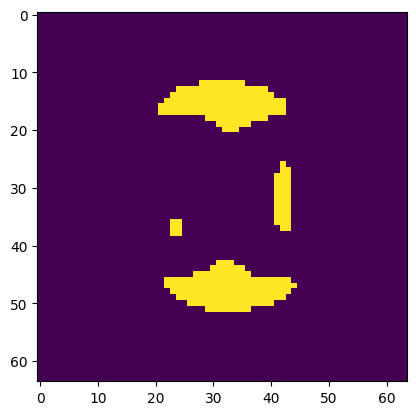

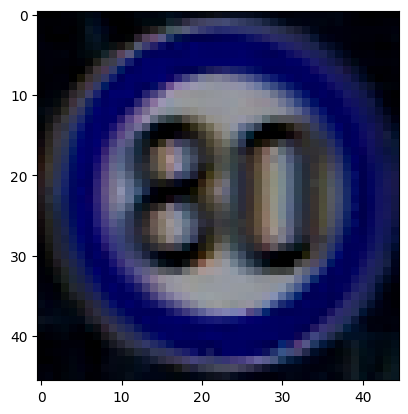

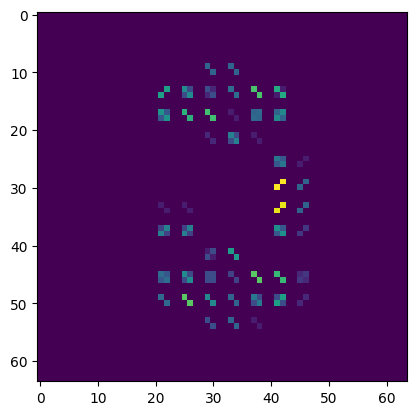

Predicted Class:  5


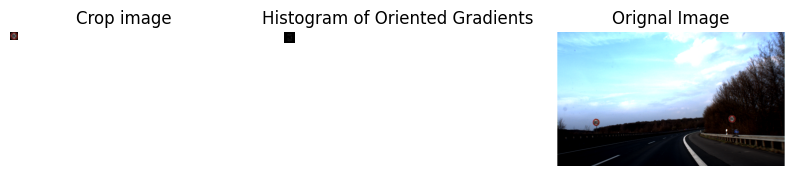

<Figure size 640x480 with 0 Axes>

In [31]:
from skimage.exposure import exposure
image_number = 704
img_path='FullIJCNN2013/normalized/' + df['file'][image_number].replace(".ppm", "_norm.ppm") 
print ('Reading Image from Path: ',img_path)
img = cv2.imread(img_path)
crop_image=img[df['y1'][image_number]:df['y2'][image_number], df['x1'][image_number]:df['x2'][image_number]]

img0=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img0 = cv2.medianBlur(img0,3)

crop_image0=img0[df['y1'][image_number]:df['y2'][image_number], df['x1'][image_number]:df['x2'][image_number]]
crop_image0=cv2.resize(crop_image0, (64, 64))
# Apply Hog from skimage library it takes image as crop image.Number of orientation bins that gradient
# need to calculate.
ret,crop_image0 = cv2.threshold(crop_image0,127,255,cv2.THRESH_BINARY)
descriptor,imagehog  = hog(crop_image0, orientations=8,pixels_per_cell=(4,4),visualize=True)
plt.imshow(crop_image0)
plt.show()
plt.imshow(crop_image)
plt.show()
plt.imshow(imagehog)
plt.show()


# descriptor,imagehog = hog(crop_image0, orientations=8, visualize=True)
descriptor_pca=pca.transform(descriptor.reshape(1,-1))

# Initilize the 3 axis so that we can plot side by side
fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(10, 10), sharex=True, sharey=True)

#ploting crop image
ax1.axis('off')
ax1.imshow(cv2.cvtColor(crop_image,cv2.COLOR_BGR2RGB), cmap=plt.cm.gray)
ax1.set_title('Crop image')

# Rescale histogram for better display,Return image after stretching or shrinking its intensity levels
hog_image_rescaled = exposure.rescale_intensity(imagehog, in_range=(0, 10))
#ploting Hog image
ax2.axis('off')
ax2.imshow(imagehog, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
#ploting Orignal image
ax3.axis('off')
ax3.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB), cmap=plt.cm.gray)
ax3.set_title('Orignal Image')
# class predition of image using SVM
Predicted_Class=classifier.predict(descriptor_pca)[0]
print ('Predicted Class: ',Predicted_Class)

fig = plt.figure()
fig.suptitle('Class Ground Truth Image')
plt.show()